|| Feature Selection using Particle Selection Optimization ||

In [1]:
import numpy as np
import sklearn
import matplotlib
import ReliefF 
import pandas as pd


In [2]:
#import dataset
X_train = pd.read_csv('dataset-after-preparation/X_train.csv')
X_test = pd.read_csv('dataset-after-preparation/X_test.csv')
y_train = pd.read_csv('dataset-after-preparation/y_train.csv')
y_test = pd.read_csv('dataset-after-preparation/y_test.csv')

In [3]:
y_train = y_train.iloc[:,-1]
X_train = X_train.iloc[:,2:]


                          Iteration - 1


Number of agents: 20

------------- Best Agent ---------------
Fitness: 0.7051421883239656
Number of Features: 8378
----------------------------------------

Particle 1 - Fitness: 0.7051421883239656, Number of Features: 8378
Particle 2 - Fitness: 0.7047505434153494, Number of Features: 8465
Particle 3 - Fitness: 0.7047055267591866, Number of Features: 8475
Particle 4 - Fitness: 0.7042958751881053, Number of Features: 8566
Particle 5 - Fitness: 0.704291373522489, Number of Features: 8567
Particle 6 - Fitness: 0.7042103435413961, Number of Features: 8585
Particle 7 - Fitness: 0.703674645333059, Number of Features: 8704
Particle 8 - Fitness: 0.7035756086895009, Number of Features: 8726
Particle 9 - Fitness: 0.703512585370873, Number of Features: 8740
Particle 10 - Fitness: 0.7028688471877452, Number of Features: 8883
Particle 11 - Fitness: 0.7024907072759778, Number of Features: 8967
Particle 12 - Fitness: 0.7016173841464199, Number of Features: 

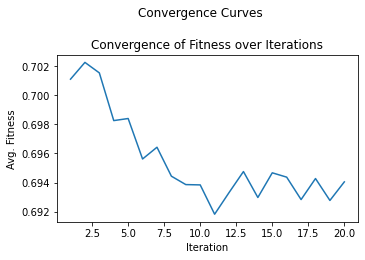

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

from Py_FS.wrapper.nature_inspired._utilities import Solution, Data, initialize, sort_agents, display, compute_fitness, Conv_plot
from Py_FS.wrapper.nature_inspired._transfer_functions import get_trans_function


def PSO(num_agents, max_iter, weight_acc, train_data, train_label, obj_function=compute_fitness, trans_func_shape='s', save_conv_graph=False):
    
    # Particle Swarm Optimizer
    ############################### Parameters ####################################
    #                                                                             #
    #   num_agents: number of particles                                           #
    #   max_iter: maximum number of generations                                   #
    #   train_data: training samples of data                                      #
    #   train_label: class labels for the training samples                        #                
    #   obj_function: the function to maximize while doing feature selection      #
    #   trans_function_shape: shape of the transfer function used                 #
    #   save_conv_graph: boolean value for saving convergence graph               #
    #                                                                             #
    ###############################################################################
    
    short_name = 'PSO'
    agent_name = 'Particle'
    train_data, train_label = np.array(train_data), np.array(train_label)
    num_features = train_data.shape[1]
    trans_function = get_trans_function(trans_func_shape)
    
    # setting up the objectives
    weight_acc = None
    if(obj_function==compute_fitness):
        # weight_acc = float(input('Weight for the classification accuracy [0-1]: '))
        weight_acc = weight_acc 
    obj = (obj_function, weight_acc)
    compute_accuracy = (compute_fitness, 1) # compute_accuracy is just compute_fitness with accuracy weight as 1

    # initialize particles and Leader (the agent with the max fitness)
    particles = initialize(num_agents, num_features)
    fitness = np.zeros(num_agents)
    accuracy = np.zeros(num_agents)
    Leader_agent = np.zeros((1, num_features))
    Leader_fitness = float("-inf")
    Leader_accuracy = float("-inf")

    # initialize convergence curves
    convergence_curve = {}
    convergence_curve['fitness'] = np.zeros(max_iter)

    # initialize data class
    
    data = Data()
    val_size = 0.3
    # val_size = float(input('Enter the percentage of data wanted for valdiation [0, 100]: '))/100
    data.train_X, data.val_X, data.train_Y, data.val_Y = train_test_split(train_data, train_label, stratify=train_label, test_size=val_size)
    

    # create a solution object
    solution = Solution()
    solution.num_agents = num_agents
    solution.max_iter = max_iter
    solution.num_features = num_features
    solution.obj_function = obj_function

    # rank initial particles
    particles, fitness = sort_agents(particles, obj, data)

    # start timer
    start_time = time.time()

    # initialize global and local best particles
    globalBestParticle = [0 for i in range(num_features)]
    globalBestFitness = float("-inf")
    localBestParticle = [ [ 0 for i in range(num_features) ] for j in range(num_agents) ] 
    localBestFitness = [float("-inf") for i in range(num_agents) ]
    weight = 1.0 
    velocity = [ [ 0.0 for i in range(num_features) ] for j in range(num_agents) ]
    
    for iter_no in range(max_iter):
        print('\n================================================================================')
        print('                          Iteration - {}'.format(iter_no+1))
        print('================================================================================\n')
        
        # update weight
        weight = 1.0 - (iter_no / max_iter)
        
        # update the velocity
        for i in range(num_agents):
            for j in range(num_features):
                velocity[i][j] = (weight*velocity[i][j])
                r1, r2 = np.random.random(2)
                velocity[i][j] = velocity[i][j] + (r1 * (localBestParticle[i][j] - particles[i][j]))
                velocity[i][j] = velocity[i][j] + (r2 * (globalBestParticle[j] - particles[i][j]))
       
        # updating position of particles
        for i in range(num_agents):
            for j in range(num_features):
                trans_value = trans_function(velocity[i][j])
                if (np.random.random() < trans_value): 
                    particles[i][j] = 1
                else:
                    particles[i][j] = 0
                 
        # updating fitness of particles
        particles, fitness = sort_agents(particles, obj, data)
        display(particles, fitness, agent_name)
        
        
        # updating the global best and local best particles
        for i in range(num_agents):
            if fitness[i]>localBestFitness[i]:
                localBestFitness[i]=fitness[i]
                localBestParticle[i]=particles[i][:]

            if fitness[i]>globalBestFitness:
                globalBestFitness=fitness[i]
                globalBestParticle=particles[i][:]

        # update Leader (best agent)
        if globalBestFitness > Leader_fitness:
            Leader_agent = globalBestParticle.copy()
            Leader_fitness = globalBestFitness.copy()

        convergence_curve['fitness'][iter_no] = np.mean(fitness)

    # compute final accuracy
    Leader_agent, Leader_accuracy = sort_agents(Leader_agent, compute_accuracy, data)
    particles, accuracy = sort_agents(particles, compute_accuracy, data)

    print('\n================================================================================')
    print('                                    Final Result                                  ')
    print('================================================================================\n')
    print('Leader ' + agent_name + ' Dimension : {}'.format(int(np.sum(Leader_agent))))
    print('Leader ' + agent_name + ' Fitness : {}'.format(Leader_fitness))
    print('Leader ' + agent_name + ' Classification Accuracy : {}'.format(Leader_accuracy))
    print('\n================================================================================\n')

    # stop timer
    end_time = time.time()
    exec_time = end_time - start_time

    # plot convergence graph
    fig, axes = Conv_plot(convergence_curve)
    # if(save_conv_graph):
    #     plt.savefig('convergence_graph_'+ short_name + '.jpg')
    plt.show()

    # update attributes of solution
    solution.best_agent = Leader_agent
    solution.best_fitness = Leader_fitness
    solution.best_accuracy = Leader_accuracy
    solution.convergence_curve = convergence_curve
    solution.final_particles = particles
    solution.final_fitness = fitness
    solution.final_accuracy = accuracy
    solution.execution_time = exec_time

    return solution


if __name__ == '__main__': 
    
    data = datasets.load_digits()
    PSO(20, 20, 0.8, X_train, y_train, save_conv_graph=True)